# AMPA synapse model

## Model overview

AMPA receptor is an ionotropic receptor of neurotransmitter `Glutamate`. After being bound by Glutamate, it opens the sodium and potassium ion channels and induce postsynaptic current.

AMPA receptor plays important role in long-term potentiation.

This synapse model describes the transmitter-activated ion channel with synaptic conductance $g_{syn}(t)$.

## Implementation

Our implementation is based on BrainPy framework.

In [1]:
import brainpy as bp
from brainpy import numpy as np

A synapse model include two neuron models and a synapse, we will import the LIF neuron model first.

In [2]:
#from examples.neurons.LIF_model import LIF

def define_LIF(tau=10., Vr=0., Vth=10., noise=0., ref=0.):
    """Leaky integrate-and-fire neuron model.

    Parameters
    ----------
    tau : float
        Membrane time constants.
    Vr : float
        The reset potential.
    Vth : float
        The spike threshold.
    noise : float, callable
        The noise item.
    ref : float
        The refractory period.
    """

    ST = bp.types.NeuState(
        {'V': 0, 'sp_t': -1e7, 'sp': 0., 'inp': 0.},
    )

    @bp.integrate
    def int_f(V, t, Isyn):
        return (-V + Vr + Isyn) / tau, noise / tau

    def update(ST, _t_):
        if _t_ - ST['sp_t'] > ref:
            V = int_f(ST['V'], _t_, ST['inp'])
            if V >= Vth:
                V = Vr
                ST['sp_t'] = _t_
                ST['sp'] = True
            ST['V'] = V
        else:
            ST['sp'] = False
        ST['inp'] = 0.

    return bp.NeuType(name='LIF', requires=dict(ST=ST), steps=update, vector_based=False)

Let's take a look at two types of AMPA receptors.

### AMPA 1

Simple one?? Only one exponential decay.

The synaptic current $I_{syn}$ is given by: 

$$I_{syn}= g_{syn} (V-E_{syn})$$

where $V$ is the membrane potential (of the synaptic channel???).

$$g_{syn} = \bar{g}_{syn} s $$

where $\bar{g}_{syn}$ is the maximum synaptic conductance. The reversal potential $E_{syn}$ for AMPA receptor is $0$.

$s$ is the gating variable representing the fraction of open synaptical channel, it's dynamic is given by:

$$\frac{d s}{d t}=-\frac{s}{\tau_{decay}}+\sum_{k} \delta(t-t_{j}^{k})$$

where $\tau_{decay}$ is around 2 to 5 ms.

In [3]:
E_SYN = 0.
TAU = 2.

def AMPA1(g_max=0.10, E=E_SYN, tau_decay=TAU):
    """AMPA conductance-based synapse (type 1).

    Parameters
    ----------
    g_max : float
        Maximum conductance.
    E : float
        Reversal potential.
    tau_decay : float
        Tau for decay.
    """

    requires = dict(
        ST=bp.types.SynState(['s'], help='AMPA synapse state.'),
        pre=bp.types.NeuState(['sp'], help='Pre-synaptic neuron state must have "sp" item.'),
        post=bp.types.NeuState(['V', 'inp'], help='Pre-synaptic neuron state must have "V" and "inp" item.'),
    )

    @bp.integrate
    def ints(s, t):
        return - s / tau_decay

    def update(ST, _t_, pre):
        s = ints(ST['s'], _t_)
        s += pre['sp']
        ST['s'] = s

    @bp.delayed
    def output(ST, post):
        post_val = - g_max * ST['s'] * (post['V'] - E)
        post['inp'] += post_val

    return bp.SynType(name='AMPA', requires=requires, steps=(update, output), vector_based=False)


### AMPA 2

We can also make a model which has the flavor of a Hodgkin-Huxley channel.

The synaptic current is given by:

$$ I_{syn}=\bar{g}_{syn} s (V-E_{syn}) $$

where the dynamics of gating variable $s$ is given by:

$$ \frac{ds}{dt} =\alpha[T](1-s)-\beta s $$

where $\alpha$ and $\beta$ are the binding constant and unbinding constant, respectively; $[T]$ is the neurotransmitter that channels open when neurotransmitter $[T]$ binds to the synapse.

In [4]:
def AMPA2(g_max=0.42, E=E_SYN, alpha=0.98, beta=0.18, T=0.5, T_duration=0.5):
    """AMPA conductance-based synapse (type 2).

    Parameters
    ----------
    g_max : float
        Maximum conductance.
    E : float
        Reversal potential.
    alpha
    beta
    T
    T_duration
    """

    requires = {
        'ST': bp.types.SynState({'s': 0., 'sp_t': -1e7},
                                help=""" "s": Synaptic state.
                                    "sp_t": Pre-synaptic neuron spike time.
                                """),
        'pre': bp.types.NeuState(['sp'], help='Pre-synaptic neuron state must have "sp" item.'),
        'post': bp.types.NeuState(['V', 'inp'], help='Pre-synaptic neuron state must have "V" and "inp" item.'),
    }

    @bp.integrate
    def int_s(s, t, TT):
        return alpha * TT * (1 - s) - beta * s

    def update(ST, _t_, pre):
        if pre['sp'] > 0.:
            ST['sp_t'] = _t_
        TT = ((_t_ - ST['sp_t']) < T_duration) * T
        s = np.clip(int_s(ST['s'], _t_, TT), 0., 1.)
        ST['s'] = s

    @bp.delayed
    def output(ST, post):
        post_val = - g_max * ST['s'] * (post['V'] - E)
        post['inp'] += post_val

    return bp.SynType(name='AMPA', requires=requires, steps=(update, output), vector_based=False)


We implement the delay of the synapse (from pre to post) by using the decorator `@bp.delayed` before the `output` function which updating the post synaptic input.

### Simulation

Let's define a function to simulate the progress of pre->ampa->post.

We'll apply the current to the synapse (inject action potential to the pre-synaptic neuron by give input to `'pre.sp'`)

In [5]:
import matplotlib.pyplot as plt

def run_ampa_single(cls, Iext, duration, sim_pos = 'pre.sp'):
    '''
    Run single simulation with AMPA synapse.
    
    Args:
        cls (SynType): model.
        Iext (NPArray): external current.
        duration (float): duration of the external current.
        sim_pos (string): position that is given the exernal current, default = 'pre.sp'.
    '''
    LIF = define_LIF()
    pre = bp.NeuGroup(LIF, 2, monitors=['sp', 'inp'])
    post = bp.NeuGroup(LIF, 3, monitors=['inp', 'V'])
    ampa = bp.SynConn(model=cls, pre_group=pre, post_group=post, conn=bp.connect.All2All(),
                      monitors=['s'], delay=10.)

    # set ampa behaviour
    ampa.runner.set_schedule(['input', 'update', 'output', 'monitor'])

    # build network connection (pre-> ampa-> post)
    net = bp.Network(pre, ampa, post)
        
    # run simulation
    net.run(duration, inputs=(ampa, sim_pos, Iext, '='), report=False)

    # visualization
    fig, gs = bp.visualize.get_figure(2, 1, 5, 6)
    
    # synapse
    fig.add_subplot(gs[0, 0])
    plt.plot(net.ts, ampa.mon.s[:, 0], label='gating variable')
    plt.plot(net.ts, pre.mon.sp[:, 0], label='pre spike')
    plt.ylabel('gating variable')
    plt.xlabel('Time (ms)')
    plt.title('synapse dynamics')
    plt.legend()
    
    # post input (synapse output)
    fig.add_subplot(gs[1, 0])
    plt.plot(net.ts, post.mon.inp[:, 0], label='post_input')
    plt.ylabel('post input potential (mV)')
    plt.xlabel('Time (ms)')
    plt.title('post input potential')
    plt.legend()
    plt.show()

Like neuron models, we set the profile before run simulation.

In [6]:
bp.profile.set(backend='numpy', merge_steps=True, dt=0.1)

Run simulation for AMPA1, with spike current.

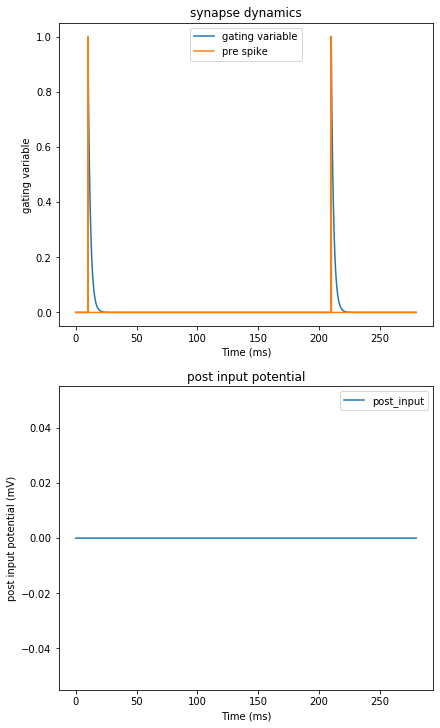

In [7]:
# get input current
amplitudes = [10, 210, 410, 610]
duration = 70. * len(amplitudes)
spike_I = bp.inputs.spike_current(amplitudes, bp.profile._dt, 1., duration=duration)

run_ampa_single(cls = AMPA1(), Iext = spike_I, duration = duration)

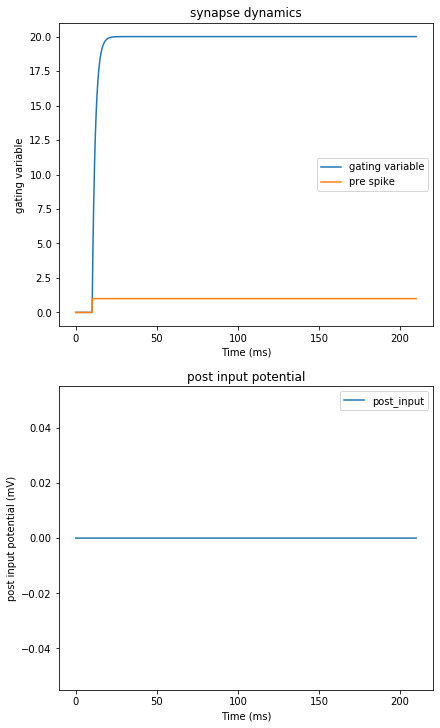

In [8]:
# step current parameters
amplitude = 556.9  # step current amplitude
stim_start = 10. # stimulation start point
stim_t = 100.   # stimulation duration
post_stim_t = 100. # after stimulation time

# generate step current
I = [(0, stim_start), (amplitude, stim_t), (0, post_stim_t)]
(step_I, duration) = bp.inputs.constant_current(I)

run_ampa_single(cls = AMPA1(), Iext = step_I, 
                duration = duration, sim_pos = 'pre.inp')

Run simulation for AMPA2

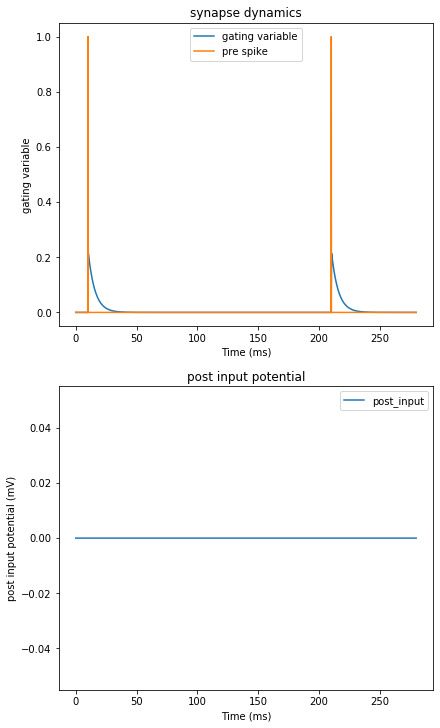

In [9]:
# get input current
amplitudes = [10, 210, 410, 610]
duration = 70. * len(amplitudes)
spike_I = bp.inputs.spike_current(amplitudes, bp.profile._dt, 1., duration=duration)

run_ampa_single(cls = AMPA2(), Iext = spike_I, duration = duration)

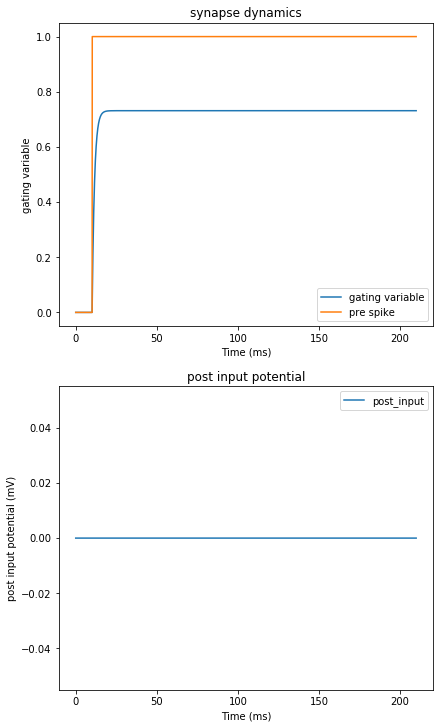

In [10]:
# step current parameters
amplitude = 556.9  # step current amplitude
stim_start = 10. # stimulation start point
stim_t = 100.   # stimulation duration
post_stim_t = 100. # after stimulation time

# generate step current
I = [(0, stim_start), (amplitude, stim_t), (0, post_stim_t)]
(step_I, duration) = bp.inputs.constant_current(I)

run_ampa_single(cls = AMPA2(), Iext = step_I, 
                duration = duration, sim_pos = 'pre.inp')